In [1]:
import numpy as np
import pylab as plt
from tqdm import tqdm
from matplotlib import cm
from matplotlib.ticker import LinearLocator

In [2]:
# https://hal.archives-ouvertes.fr/hal-00921656v1/document
# https://hal.archives-ouvertes.fr/hal-00921656v2/document
# https://www.researchgate.net/publication/281441538_An_introduction_to_the_Split_Step_Fourier_Method_using_MATLAB

# metrology
ps = 1e-12
km = 1e3
µm = 1e-6
nm = 1e-9

# Constants
c= 3e8

# Laser Properties

P0 = 0.5 # Lasing power
λ = 1550 * nm # wavelength
f0 = 1e10 # modulation frequency
T0 = 1/f0

# Fiber properties (SFM 28)
L = 5e3 # Delay line
neff = 1.5
D = - 20 * ps / nm / km # Dispersion factor
α = 0#0.046 / km # Fiber losses
β2 = -λ**2*D/(2*np.pi*c) # Dispersion constnant
#n2 =  2.4e-20  # non-linear index (SPM)
#Aeff = 70 * (µm)**2 # Effective core area
γ = 1.1 / km #0.78 / km #2*np.pi*n2/(λ*Aeff) # Non-linear factor

# Parameters


Nt = int(20000) # Time sampling size
Nz = int(10000) # Space sampling size
n = 1# Time window factor
T = np.linspace(-n*T0,+n*T0, Nt) # Time vector (local)
dt = T[1]-T[0] # Timestep
F = (np.fft.fftfreq(Nt,d=dt)) # Frequency vector

δ = 0*1.5*np.pi
θ = np.pi/2
h = L/Nz # Space-step


A = np.zeros((Nz, Nt), dtype=complex) # Local-Time/Space Field matrix
S = np.zeros((Nz, Nt), dtype=complex) # Frequency/Space Field Matrix

A0 = np.sqrt(P0)*np.cos(np.pi*T/T0)**2#+ np.sqrt(P0/10000)*np.random.randn(Nt) # Initial Pulse
A0 = A0*np.exp(1j*δ*np.abs(A0)*np.cos(2*np.pi*f0*T+θ))
# Initialization
A[0,:] = A0
S[0,:] = np.fft.fft(A0)

In [3]:
D = -β2*0.5*1j*(2*np.pi*F)**2 - 0.5*α # Calculate Dispersion operator

In [4]:
def next_step(A): # Calculates the value of the pulse fied after a propagation of length h
    N = 1j*γ*np.abs(A)**2 # Nonlinear operator
    Ai = np.exp(0.5*h*D)*np.fft.fft(A) # disp on half step
    Ai = np.exp(h*N)*np.fft.ifft(Ai) # full step NL
    Ai = np.exp(0.5*h*D)*np.fft.fft(Ai) # disp on half step
    return  np.fft.ifft(Ai)

In [5]:
for i in tqdm(range(1,Nz)): # Space iteration (Delay line)
    A[i,:] = next_step(A[i-1,:])
    S[i,:] = np.fft.fftshift(np.fft.fft(A[i,:]))

100%|██████████| 9999/9999 [00:45<00:00, 217.49it/s]


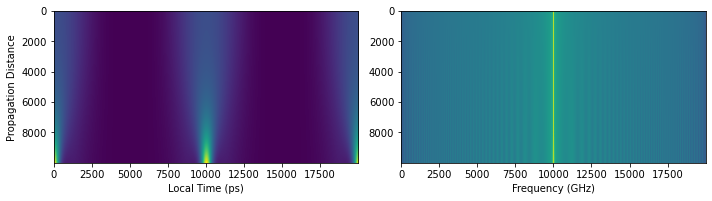

In [6]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(np.abs(A)**2, aspect=1)
plt.xlabel(r"Local Time (ps)")
plt.ylabel(r"Propagation Distance")
plt.subplot(1,2,2)
plt.imshow(np.log10(np.abs(S)**2))
plt.gca().set_aspect("equal")
plt.xlabel(r"Frequency (GHz)")
plt.tight_layout()
plt.show()

[]

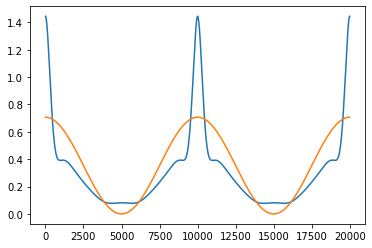

In [7]:
lmax = np.argmax(np.abs(A[:,0]))
plt.plot(np.abs(A[-1,:]))
plt.plot(np.abs(A[0,:]))
plt.plot()

In [265]:
print("Energy in : {:.2e} / Energy out : {:.2e}".format(np.sum(np.abs(A[0,:])**2)*dt,np.sum(np.abs(A[lmax,:])**2)*dt))

Energy in : 7.50e-11 / Energy out : 7.50e-11


In [270]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

l = np.linspace(0,L, Nz)
t,ll = np.meshgrid(T, l)
surf = ax.plot_surface(t/ps, ll/km,np.abs(A)**2, antialiased=True, cmap='viridis')
ax.set_xlabel(r"Local time (ps)")
ax.set_ylabel(r"Distance (km)")
ax.set_zlabel(r"Power (W)")
plt.show()